# 3. Clasificación de subtópicos 

* Debido a que existían tópicos los cuales contenían noticias que podríamos asignar a más de una categoría optamos por realizar un segundo LDA.

## Imports y definición de funciones

In [1]:
import numpy as np
import pandas as pd
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel


# Plotting tools
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
from my_funcs import get_df_keywords

import ast

In [24]:
class Coherencio:
    def __init__(self, df, start, limit=None, step=None, stop_words=None):
        self.get_from_textlist(df, stop_words)
        self.start = start
        self.limit = limit if limit is not None else start + 1
        self.step = step if step is not None else 1
        self.best_model = None
        self.model_list = []
        
    def get_from_textlist(self, df, stop_words):
        self.data_lemmatized = []
        if 'text_list' in df.columns:
            list_data_lemmatized = df["text_list"].tolist()
            for lista in tqdm(list_data_lemmatized, desc='DATA LEMMATIZED'):
                if isinstance(lista, list):
                    self.data_lemmatized.append(lista)
                else:
                    self.data_lemmatized.append(ast.literal_eval(lista)
            )
        else:
            print('text_list not found')
            return
        # Create Dictionary
        self.id2word = corpora.Dictionary(self.data_lemmatized)
        # Create Corpus
        texts = self.data_lemmatized
        if stop_words is not None:
            desc = "Removing stopwords"
            texts = [[word for word in doc if word not in stop_words] for doc in tqdm(texts, desc=desc)]
        # Term Document Frequency
        self.corpus = [self.id2word.doc2bow(text) for text in tqdm(texts, desc='doc2bow')]
        
    def compute_coherence_values(self):
        """
        Compute c_v coherence for various number of topics

        Parameters:
        ----------
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

        Returns:
        -------
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
        """
        self.coherence_values = []
        for num_topics in tqdm(range(self.start, self.limit, self.step), desc='LDA MODELS'):

            #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

            model = gensim.models.ldamodel.LdaModel(corpus=self.corpus,
                                               id2word=self.id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

            self.model_list.append(model)
            coherencemodel = CoherenceModel(model=model, texts=self.data_lemmatized,
                                            dictionary=self.id2word,
                                            coherence='c_v')
            self.coherence_values.append(coherencemodel.get_coherence())
        
    def _print_coherences(self, x):
        for i, (m, cv) in enumerate(zip(x, self.coherence_values)):
            print(f" [{i}] Num Topics = {m}  has Coherence Value of {cv:.4f}")

    def plot_coherences(self):
        x = range(self.start, self.limit, self.step)
        if len(x) > 1:
            plt.plot(x, self.coherence_values)
            plt.xlabel("Num Topics")
            plt.ylabel("Coherence score")
            plt.legend(("coherence_values"), loc='best')
            plt.show()
        self._print_coherences(x)
        
    def choose_best_model(self, idx):
        if idx > len(self.model_list) - 1:
            self.best_model = self.model_list[0]
            print('error de indice')
        else:
            self.best_model = self.model_list[idx]
        self.optimal_ntopics = len(self.best_model.get_topics())
        
    def get_best_model_keywords(self):
        if self.best_model is None and self.model_list:
            self.choose_best_model(0)
        return get_df_keywords(self.best_model, self.optimal_ntopics)
        
    def format_topics_documents(self):
        # Init output
        sent_topics_df = pd.DataFrame()
        if self.best_model is None:
            self.choose_best_model(0)
        # Get main topic in each document
        for i, row_list in enumerate(tqdm(self.best_model[self.corpus], desc='Main topic')):
            row = row_list[0] if self.best_model.per_word_topics else row_list            
            # print(row)
            row = sorted(row, key=lambda x: (x[1]), reverse=True)
            # Get the Dominant topic, Perc Contribution and Keywords for each document
            for j, (topic_num, prop_topic) in enumerate((row)):
                if j == 0:  # => dominant topic
                    wp = self.best_model.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                else:
                    break
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        # Add original text to the end of the output
        contents = pd.Series(self.data_lemmatized)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        self.df_dominant_topic = sent_topics_df.reset_index()
        self.df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text_list']

    def count_per_topic(self):
        if self.df_dominant_topic is not None:
            display(self.df_dominant_topic['Dominant_Topic'].value_counts())

## Utilizando el subset de noticias sin categoría (por url y tópico), eligiendo el número de tópicos que maximice la coherencia.

A diferencia de la etapa anterior, el número de noticias restantes es un poco más manejable por lo que intentaremos encontrar el mejor número de tópicos para analizar sus palabras claves e intentar asignarles una categoría objetivo.

In [3]:
filename = './df_sin_topic.csv'
base_df = pd.read_csv(filename)[['id', 'url', 'title', 'content', 'text_list']]
base_df.head()

,id,url,title,content,text_list
0,7329456,https://www.meganoticias.cl/tendencias/320596-...,Adamari López y su lucha contra el sobrepeso: ...,Adamari López y su lucha contra el sobrepeso: ...,"['adamari_lopez', 'luchar', 'sobrepeso', 'mont..."
1,4829009,https://www.latercera.com/nacional/noticia/int...,Intendente de la RM por paro de camioneros: “I...,Intendente de la RM por paro de camioneros: “I...,"['intendente', 'paro', 'camionero', 'interrump..."
2,6343140,https://www.latercera.com/que-pasa/noticia/asi...,Así es PlayStation 5 por dentro: dan a conocer...,Así es PlayStation 5 por dentro: dan a conocer...,"['dentro', 'dar', 'conocer', 'experiencia', 'u..."
3,7355093,https://www.meganoticias.cl/tendencias/313371-...,Rafael Araneda y Marcela Vacarezza presentaron...,Rafael Araneda y Marcela Vacarezza presentaron...,"['rafael_araneda', 'marcela_vacarezza', 'prese..."
4,6321215,https://www.latercera.com/que-pasa/noticia/mis...,Mis padres se separaron en pandemia… ¿qué hago...,Mis padres se separaron en pandemia… ¿qué hago...,"['padre', 'separar', 'parte', 'llegar', 'terra..."


LDA MODELS: 100%|████████████████████████████████| 8/8 [29:05<00:00, 218.15s/it]


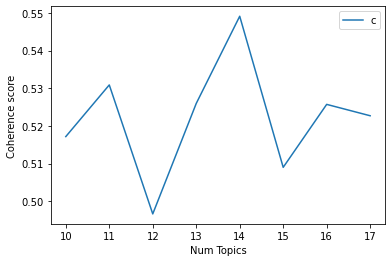

 [0] Num Topics = 10  has Coherence Value of 0.5172
 [1] Num Topics = 11  has Coherence Value of 0.5309
 [2] Num Topics = 12  has Coherence Value of 0.4966
 [3] Num Topics = 13  has Coherence Value of 0.5260
 [4] Num Topics = 14  has Coherence Value of 0.5491
 [5] Num Topics = 15  has Coherence Value of 0.5090
 [6] Num Topics = 16  has Coherence Value of 0.5257
 [7] Num Topics = 17  has Coherence Value of 0.5227


In [11]:
# cohelho = Coherencio(base_df, 14)
cohelho = Coherencio(base_df, 10, limit=18, step=1)
cohelho.compute_coherence_values()
cohelho.plot_coherences()

In [17]:
# si se hace con un solo num_topics se puede omitir
#cohelho.choose_best_model(4)
cohelho.format_topics_documents()
cohelho.count_per_topic()

Main topic: 100%|█████████████████████████| 12467/12467 [02:20<00:00, 88.46it/s]


0.0     3394
4.0     2752
2.0     1848
5.0     1658
9.0     1188
3.0      664
10.0     338
11.0     232
8.0      145
1.0      123
12.0      87
13.0      38
Name: Dominant_Topic, dtype: int64

In [18]:
cohelho.df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,2.0,0.4881,"post_on, instagrama_post, view_this, post_shar...","[adamari_lopez, luchar, sobrepeso, montana_rus..."
1,1,0.0,0.3122,"persona, paso, medida, comuna, salud, semana, ...","[intendente, paro, camionero, interrumpir, lib..."
2,2,9.0,0.4298,"millón, ano, estudio, mayor, explicar, acceder...","[dentro, dar, conocer, experiencia, usuario, n..."
3,3,2.0,0.7350,"post_on, instagrama_post, view_this, post_shar...","[rafael_araneda, marcela_vacarezza, presentar,..."
4,4,4.0,0.6317,"hacer, decir, ver, dar, mas, tambien, bien, qu...","[padre, separar, parte, llegar, terraza, cafe,..."
...,...,...,...,...,...
12462,12462,9.0,0.5047,"millón, ano, estudio, mayor, explicar, acceder...","[presentar, bajo, nivel, sustentabilidad, cost..."
12463,12463,4.0,0.3577,"hacer, decir, ver, dar, mas, tambien, bien, qu...","[analisi, director, aumento, homicidio, direct..."
12464,12464,4.0,0.4063,"hacer, decir, ver, dar, mas, tambien, bien, qu...","[partar, desafio, vislumbrar, nuevo, director,..."
12465,12465,2.0,0.3713,"post_on, instagrama_post, view_this, post_shar...","[mes, tension, raquel_perero, lograr, acuerdo,..."


### Nos enfocaremos en las categorias que poseen menos noticias hasta el momento

del paso anterior:

```
                category 	count(*)
                
                
1-Mundo 	                    8609
9-Crimen_delitos_y_Justicia 	8213
3-Política_y_Conflictos 	    7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
```

In [19]:
cohelho.get_best_model_keywords()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,persona,colegio,post_on,nuevo,hacer,caso,mascota,color,region,millón,ano,hecho,politico,serie
1,paso,clase,instagrama_post,proyecto,decir,nuevo,esposa,diseno,comuna,ano,primero,carabinero,presidente,personaje
2,medida,presencial,view_this,nacional,ver,total,jugador,urbano,casos_activo,estudio,mujer,luego,derecho,actor
3,comuna,educacion,post_shared,proceso,dar,contagio,robo,marca,lago,mayor,mundo,caso,gobierno,estadounidense
4,salud,alumno,shared_by,social,mas,nivel,pueblos_originario,temperatura,biobio,explicar,nuevo,persona,ministro,temporada
5,semana,estudiante,by,trabajo,tambien,cifra,colo_colo,parque,nota_tabla_emol_tablaennoticia,acceder,vida,detenido,violencia,pelicula
6,hora,profesor,ano,desarrollo,bien,salud,pequena,incendio,rio,sistema,vez,encontrar,plebiscito,historia
7,autoridad,ano,hijo,recurso,querer,persona,futbol,gratuito,punta_arena,empresa,chileno,victima,diputado,estreno
8,cuarentena,nino,foto,presidente,tener,nacional,club,madera,tasa,tambien,gran,denuncia,partido,papel
9,plan,escuela,famoso,buscar,creer,región,listado,integracion,zona,mas,solo,interior,rechazo,produccion


In [20]:
important_topics = [2.0, 4.0, 6.0, 7.0, 8.0, 9.0, 10.0, 13.0]
df_topics = base_df.copy()
mask = cohelho.df_dominant_topic.Dominant_Topic.isin(important_topics)
df_topics = df_topics[mask.reindex(df_topics.index, fill_value=False)]
df_topics

,id,url,title,content,text_list
0,7329456,https://www.meganoticias.cl/tendencias/320596-...,Adamari López y su lucha contra el sobrepeso: ...,Adamari López y su lucha contra el sobrepeso: ...,"['adamari_lopez', 'luchar', 'sobrepeso', 'mont..."
2,6343140,https://www.latercera.com/que-pasa/noticia/asi...,Así es PlayStation 5 por dentro: dan a conocer...,Así es PlayStation 5 por dentro: dan a conocer...,"['dentro', 'dar', 'conocer', 'experiencia', 'u..."
3,7355093,https://www.meganoticias.cl/tendencias/313371-...,Rafael Araneda y Marcela Vacarezza presentaron...,Rafael Araneda y Marcela Vacarezza presentaron...,"['rafael_araneda', 'marcela_vacarezza', 'prese..."
4,6321215,https://www.latercera.com/que-pasa/noticia/mis...,Mis padres se separaron en pandemia… ¿qué hago...,Mis padres se separaron en pandemia… ¿qué hago...,"['padre', 'separar', 'parte', 'llegar', 'terra..."
7,97595,https://www.biobiochile.cl/noticias/nacional/c...,"Ministro Desbordes y propuesta de J.A. Kast: ""...","Ministro Desbordes y propuesta de J.A. Kast: ""...","['ministro', 'propuesto', 'tratar', 'traidor',..."
...,...,...,...,...,...
12462,5165171,https://www.elciudadano.com/chile/el-90-del-ar...,El 90% del área de la Bahía de Concón presenta...,El 90% del área de la Bahía de Concón presenta...,"['presentar', 'bajo', 'nivel', 'sustentabilida..."
12463,3806849,https://www.elmostrador.cl/noticias/pais/2021/...,El análisis del director de la PDI sobre el au...,El análisis del director de la PDI sobre el au...,"['analisi', 'director', 'aumento', 'homicidio'..."
12464,13446036,https://www.emol.com/noticias/Nacional/2020/11...,"""Que no parta de cero"": Los desafíos que se vi...","""Que no parta de cero"": Los desafíos que se vi...","['partar', 'desafio', 'vislumbrar', 'nuevo', '..."
12465,7357353,https://www.meganoticias.cl/tendencias/312482-...,Tras meses de tensión: Alejandro Sanz y Raquel...,Tras meses de tensión: Alejandro Sanz y Raquel...,"['mes', 'tension', 'raquel_perero', 'lograr', ..."


### Repetimos el proceso anterior ahora para una cantidad mas acotada de topicos y con un mayor rango de búsqueda para la coeherencia

In [21]:
# quitaremos algunas palabras que no entregan mucha informacion
stop_words = ['persona', 'post_on', 'instagrama_post', 'view_this', 'post_shared',
              'shared_by', 'by', 'ano', 'hacer', 'decir', 'ver', 'dar',
              'mas', 'tambien', 'bien', 'querer', 'tener', 'gente']

LDA MODELS: 100%|█████████████████████████████████| 6/6 [06:49<00:00, 68.33s/it]


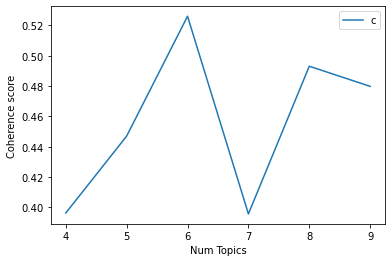

 [0] Num Topics = 4  has Coherence Value of 0.3963
 [1] Num Topics = 5  has Coherence Value of 0.4470
 [2] Num Topics = 6  has Coherence Value of 0.5261
 [3] Num Topics = 7  has Coherence Value of 0.3957
 [4] Num Topics = 8  has Coherence Value of 0.4931
 [5] Num Topics = 9  has Coherence Value of 0.4798


In [25]:
cohelho = Coherencio(df_topics, 4, limit=10, step=1, stop_words=stop_words)
cohelho.compute_coherence_values()
cohelho.plot_coherences()

In [26]:
cohelho.choose_best_model(2)
cohelho.format_topics_documents()
cohelho.count_per_topic()

Main topic: 100%|██████████████████████████| 6309/6309 [00:45<00:00, 140.19it/s]


5.0    1994
2.0    1349
0.0    1322
3.0     838
4.0     655
1.0     151
Name: Dominant_Topic, dtype: int64

In [27]:
cohelho.df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,text_list
0,0,3.0,0.6171,"pasar, vida, mujer, vez, momento, ahora, habla...","[adamari_lopez, luchar, sobrepeso, montana_rus..."
1,1,2.0,0.6294,"estudio, solo, explicar, nuevo, encontrar, mil...","[dentro, dar, conocer, experiencia, usuario, n..."
2,2,5.0,0.8025,"hijo, redes_social, nuevo, cantante, famoso, c...","[rafael_araneda, marcela_vacarezza, presentar,..."
3,3,3.0,0.7859,"pasar, vida, mujer, vez, momento, ahora, habla...","[padre, separar, parte, llegar, terraza, cafe,..."
4,4,0.0,0.7432,"politico, presidente, cambio, creer, instituci...","[ministro, propuesto, tratar, traidor, luego, ..."
...,...,...,...,...,...
6304,6304,2.0,0.7781,"estudio, solo, explicar, nuevo, encontrar, mil...","[presentar, bajo, nivel, sustentabilidad, cost..."
6305,6305,0.0,0.6474,"politico, presidente, cambio, creer, instituci...","[analisi, director, aumento, homicidio, direct..."
6306,6306,0.0,0.8266,"politico, presidente, cambio, creer, instituci...","[partar, desafio, vislumbrar, nuevo, director,..."
6307,6307,0.0,0.3803,"politico, presidente, cambio, creer, instituci...","[mes, tension, raquel_perero, lograr, acuerdo,..."


### Analizamos las palabras claves y algunas noticias de cada topico

In [29]:
cohelho.get_best_model_keywords()

,0,1,2,3,4,5
0,politico,nota_tabla_emol_tablaennoticia,estudio,pasar,salud,hijo
1,presidente,tr_td,solo,vida,caso,redes_social
2,cambio,comuna,explicar,mujer,mes,nuevo
3,creer,casos_activo,nuevo,vez,medico,cantante
4,institucion,lago,encontrar,momento,mayor,famoso
5,proceso,biobio,millón,ahora,situacion,contar
6,general,lunes,producto,hablar,familia,primero
7,nuevo,común,acceder,siempre,medida,foto
8,parte,text_align,primero,cosa,nino,video
9,gobierno,height_px,uso,solo,colegio,actriz


In [28]:
pd.set_option('display.max_colwidth', 200)
# por ejemplo vemos noticias del topico 4, posiblemente categoria salud
mask = cohelho.df_dominant_topic['Dominant_Topic'] == 4
df_topics.reset_index()[mask][['id', 'content']]

,id,content
17,13488197,"25% de hogares que perdieron ingresos en pandemia sufre inseguridad alimentaria. La Encuesta Social Covid-19 midió entre otras cosas el nivel de inseguridad alimentaria, es decir, la incertidumbre..."
18,4793858,"Subsecretario Zúñiga: “Estamos muy preocupados con el nivel de contagios que están teniendo las comunas de Rancagua, Graneros y San Fernando”. Esta tarde, el subsecretario de Redes Asistenciales, ..."
19,6334269,"Violencia digital: Un 32% de niñas entre 12 a 14 años recibió peticiones sexuales o le pidieron fotografías íntimas. La violencia de género no distingue edad. Mujeres, niños, niñas y adolescentes ..."
24,4788034,"El 48% de los médicos del país atiende a pacientes de Fonasa por la vía de la compra de bonos. De acuerdo con la Superintendencia de Salud, en Chile hay 54.234 médicos registrados para ejercer su ..."
50,15703888,"La importancia de atenciones virtuales en pandemia y cómo se adaptaron a la crisis. $(function(){creaVideoDetalle(""https://tv.emol.com/detail/20200925135952261/la-importancia-de-atenciones-virtual..."
...,...,...
6266,167606,"Médicos de Magallanes indignados por minuta que los acusa de no hacer bien su trabajo en pandemia. Una minuta del Servicio de Salud de Magallanes, que llegó al nivel central del Ministerio de Salu..."
6267,9579,Acusan a una enfermera: Al menos 16 mujeres denuncian que les inyectaron silicona industrial. Al menos 16 mujeres denuncian que fueron estafadas por una ciudadana que decía ser enfermera y prometi...
6282,129360,"Según INE: 50% de las personas ocupadas en Los Lagos recibió ingresos menores a &#36;383.000 en el 2019. Según la encuesta suplementaria, entregada por el Instituto Nacional de Estadísticas (INE),..."
6285,6329947,El científico que calcula el Factor “R efectivo” para el Minsal: ¿Qué es y cómo ayuda a saber la rapidez con que se propaga una pandemia?. “Siempre que tomamos una decisión como Ministerio de Salu...


In [31]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""


# solo tomamos los que parecen acercarse mas a alguna de nuestras
# categorias
cats_dict = {0 : '3-Política_y_Conflictos',
             4 : '10-Salud',}

to_ignore = [1, 3]

for i in range(cohelho.optimal_ntopics):
    if i not in cats_dict.keys():
        cats_dict[i] = np.nan
        
cats_dict

{0: '3-Política_y_Conflictos', 4: '10-Salud', 1: nan, 2: nan, 3: nan, 5: nan}

In [32]:
df_topics.reset_index(inplace=True)
df_topics['dominant_topic'] = cohelho.df_dominant_topic['Dominant_Topic']
df_topics

,index,id,url,title,content,text_list,dominant_topic
0,0,7329456,https://www.meganoticias.cl/tendencias/320596-adamari-lopez-adelgaza-1ab.html,"Adamari López y su lucha contra el sobrepeso: ""He sido como una montaña rusa que sube y baja""","Adamari López y su lucha contra el sobrepeso: ""He sido como una montaña rusa que sube y baja"". La actriz y presentadora puertorriqueña Adamari López es una luchadora. Venció el cáncer de mama y ah...","['adamari_lopez', 'luchar', 'sobrepeso', 'montana_rusa', 'subir', 'bajo', 'actriz', 'presentadoro', 'vencio', 'cancer', 'mama', 'ahora', 'batalla', 'sobrepeso', 'vivir', 'plenitud', 'ademas', 'tra...",3.0
1,2,6343140,https://www.latercera.com/que-pasa/noticia/asi-es-playstation-5-por-dentro-dan-a-conocer-la-experiencia-que-tendra-el-usuario-al-navegar-en-la-consola/RTWZGXDXRRG5FOALS3QMTEXVV4/,Así es PlayStation 5 por dentro: dan a conocer la experiencia que tendrá el usuario al navegar en la consola,Así es PlayStation 5 por dentro: dan a conocer la experiencia que tendrá el usuario al navegar en la consola. Sony Interative Entertainment (SIE) ha compartido las características que tendrá la in...,"['dentro', 'dar', 'conocer', 'experiencia', 'usuario', 'navegar', 'consola', 'compartido', 'caracteristica', 'proximo', 'disenar', 'conectar', 'rapidamente', 'jugador', 'videojuego', 'vicepresiden...",2.0
2,3,7355093,https://www.meganoticias.cl/tendencias/313371-rafael-araneda-y-marcela-vacarezza-presentaron-a-su-hijo-benjamin-rafael-adopcion-crx12.html,Rafael Araneda y Marcela Vacarezza presentaron a su hijo Benjamín Rafael,"Rafael Araneda y Marcela Vacarezza presentaron a su hijo Benjamín Rafael. En redes sociales, los animadores de televisión, Rafael Araneda y Marcela Vacarezza, presentaron en las últimas horas a su...","['rafael_araneda', 'marcela_vacarezza', 'presentar', 'hijo', 'redes_social', 'animador', 'television', 'rafael_araneda', 'marcela_vacarezza', 'presentar', 'ultimas_hora', 'hijo', 'pequeno', 'adopt...",5.0
3,4,6321215,https://www.latercera.com/que-pasa/noticia/mis-padres-se-separaron-en-pandemia-que-hago-con-mi-papa-2-parte/HIWR4HNF25CADEYMWLZPAHW4LI/,Mis padres se separaron en pandemia… ¿qué hago con mi papá? (2ª parte),"Mis padres se separaron en pandemia… ¿qué hago con mi papá? (2ª parte). A las 11.59 llegué a la terraza de un café para reunirme con Benjamín, un cliente al que empecé a ver la semana pasada a raí...","['padre', 'separar', 'parte', 'llegar', 'terraza', 'cafe', 'reunir yo', 'cliente', 'empece', 'ver', 'semana_pasado', 'padre', 'sentado', 'leer', 'mas', 'acercar yo', 'poner', 'pie', 'evitar', 'pen...",3.0
4,7,97595,https://www.biobiochile.cl/noticias/nacional/chile/2020/10/29/ministro-desbordes-y-propuesta-de-j-a-kast-nos-trata-de-traidores-y-luego-habla-de-unidad.shtml,"Ministro Desbordes y propuesta de J.A. Kast: ""Nos trata de traidores y luego habla de unidad""","Ministro Desbordes y propuesta de J.A. Kast: ""Nos trata de traidores y luego habla de unidad"". El ministro de Defensa, Mario Desbordes, se refirió durante la mañana de este jueves a las opciones d...","['ministro', 'propuesto', 'tratar', 'traidor', 'luego', 'hablar', 'unidad', 'ministro', 'defensa', 'mario_desbord', 'refirio', 'jueves', 'opción', 'incorporar', 'partido_republicano', 'liderado', ...",0.0
...,...,...,...,...,...,...,...
6304,12462,5165171,https://www.elciudadano.com/chile/el-90-del-area-de-la-bahia-de-concon-presenta-bajos-niveles-de-sustentabilidad-costera/09/04/,El 90% del área de la Bahía de Concón presenta bajos niveles de sustentabilidad costera,El 90% del área de la Bahía de Concón presenta bajos niveles de sustentabilidad costera. El fuerte impacto de la urbanización u otras fuerzas ejercidas en las zonas costeras es una preocupación mu...,"['presentar', 'bajo', 'nivel', 'sustentabilidad', 'costero', 'fuerte', 'impacto', 'urbanizacion', 'fuerza', 'ejercido', 'zonas_costera', 'mundial', 'especialmente', 'bajo', 'paradigma', 'sostenibi...",2.0
6305,12463,3806849,https://www.elmo

In [33]:
df_topics['category'] = df_topics.apply(lambda row : cats_dict[row.dominant_topic], axis=1)

### exportamos nuesta seleccion

In [34]:
file_idx = 1

In [35]:
# con categoria
_df = df_topics[df_topics.category.notna()][['id', 'title', 'content', 'category']]
_df.to_csv(f'categorias_{file_idx}_paso2.csv', index=False)
file_idx += 1

In [36]:
# los que requieren mas lda
for i in range(cohelho.optimal_ntopics):
    # agregar solo los category == nan
    if not isinstance(cats_dict[i], str) and np.isnan(cats_dict[i]):
        if i not in to_ignore:
            sub_df = df_topics[df_topics['dominant_topic'] == i]
            sub_df = sub_df[['id', 'title', 'content', 'text_list']]
            sub_df.to_csv(f'./dominant_topics/topics_paso2_{i}.csv')
            
sub_df, _df = None, None
del sub_df, _df

## Utilizando los topicos que guardamos previamente, realizaremos un análisis para determinar el número óptimo de subtópicos dentro del tópico en cuestión.

In [57]:
# todo lo de abajo se repite para los topicos seleccionados
# topics 2 y 5
TOPIC = 5

filename = f'./dominant_topics/topics_paso2_{TOPIC}.csv'
df = pd.read_csv(filename)
cohelho = Coherencio(df, 2, limit=13, step=1)
cohelho.compute_coherence_values()

LDA MODELS: 100%|███████████████████████████████| 11/11 [02:52<00:00, 15.65s/it]


### Grafico de subtopicos ideal (mayor es mejor)
* Considerando que queremos mejorar la precision de nuestro topico debemos aumentar la cantidad de topicos dentro de esta, por lo que optamos por análizar opciones entre 2 y 10 grupos.

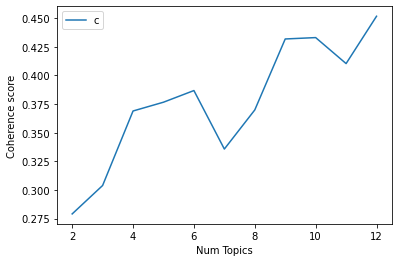

 [0] Num Topics = 2  has Coherence Value of 0.2791
 [1] Num Topics = 3  has Coherence Value of 0.3039
 [2] Num Topics = 4  has Coherence Value of 0.3689
 [3] Num Topics = 5  has Coherence Value of 0.3766
 [4] Num Topics = 6  has Coherence Value of 0.3868
 [5] Num Topics = 7  has Coherence Value of 0.3357
 [6] Num Topics = 8  has Coherence Value of 0.3699
 [7] Num Topics = 9  has Coherence Value of 0.4318
 [8] Num Topics = 10  has Coherence Value of 0.4330
 [9] Num Topics = 11  has Coherence Value of 0.4103
 [10] Num Topics = 12  has Coherence Value of 0.4517


In [39]:
cohelho.plot_coherences()

In [58]:
# elegir dependiendo de la coherencia y la cantidad de noticias por topico
# para evitar configuraciones que tienen topicos conmuy pocas noticias 
# topic 5 : idx_optimo = 4, topic 2 : idx_optimo = 4
cohelho.choose_best_model(4)
cohelho.format_topics_documents()

Main topic: 100%|██████████████████████████| 1994/1994 [00:10<00:00, 194.90it/s]


### Cantidad de noticias por topico

In [59]:
cohelho.count_per_topic()

3.0    638
1.0    597
2.0    423
4.0    253
5.0     79
0.0      4
Name: Dominant_Topic, dtype: int64

### Ver los keywords de cada topico

Analizaremos de manera manual nuevamente los topicos generados, con la intención de volver a clasificarlos.


In [60]:
cohelho.get_best_model_keywords()

,0,1,2,3,4,5
0,temporada,hacer,post_on,post_on,hacer,personaje
1,theaddymiller,post_on,view_this,instagrama_post,nuevo,nuevo
2,buddy_valastro,instagrama_post,instagrama_post,view_this,cantante,teleserie
3,alejandra_guzmar,hijo,post_shared,post_shared,artista,simon_beltran
4,filmar,view_this,shared_by,shared_by,video,capitulo
5,exesposo,post_shared,by,ano,decir,mego
6,real,decir,ver,by,tema,pantalla
7,buddyvalastro,primero,foto,actriz,ver,edificio_corón
8,meghan_markle,junto,seguidor,serie,musical,actor
9,accidente,ano,imagen,vida,fanatico,rocio


En este ejemplo podemos apreciar que las palabras claves sugieren que se trata de temas como farandula, espectaculos y redes sociales.

### Visibilizar las noticias de tópicos específicos

In [61]:
df[cohelho.df_dominant_topic['Dominant_Topic'] == 5][['id', 'content']]

,id,content
38,7344540,"Alejandra Fosalba se suma a Verdades Ocultas y adelanta: ""Nunca había hecho algo así"". Este lunes 19 de octubre Verdades Ocultas vivirá su regreso a las pantallas de Mega tras más de cinco meses d..."
82,7345242,"Matías Oviedo y regreso de Verdades Ocultas: ""Aparecerán personajes que nos van a sorprender"". Desde el próximo lunes 19 de octubre las pantallas de Mega volverán a emitir nuevos capítulos de Verd..."
86,7349025,"""Se viene una venganza enorme"": Actores de Verdades Ocultas adelantan detalles del regreso. Una semana antes de volver a las grabaciones de Verdades Ocultas, la actriz Camila Hirane aseguró que tu..."
100,7318202,"Todo vuelve a su inicio: Las teorías de ""Verdades Ocultas"" tras revelación de nuevo personaje. El reciente capítulo de este lunes en ""Verdades Ocultas"" sorprendió a los fanáticos de la teleserie, ..."
110,7321891,"""Isla Paraíso"" y ""Tranquilo papá"" regresan a las pantallas de Mega: Conoce en qué horarios. “Papá a la Deriva” está en su recta final tras ser reestrenada en la franja vespertina en mayo pasado en..."
...,...,...
1829,7308899,"""Ya no te queremos"": Seguidores de Edificio Corona enfurecidos tras actitud de Rubí con Maca. La amistad entre “Macarena” (Hiztka Nudelman) y “Rubí” (Vivianne Dietz) en “Edificio Corona” se ha ro..."
1881,7314574,"Las ""Cardenashian"" de ""Edificio Corona"" revelan detalles de sus personajes: ""Gozan el dinero"". Algunos de los personajes que más han llamado la atención en ""Edificio Corona"" han sido las denominad..."
1887,7308822,"La broma de Nicolás Oyarzún a Simón Beltrán en medio de las grabaciones de ""Edificio Corona"". Desde el debut de “Edificio Corona”, uno de los personaje que se ha robado el corazón de muchos es el ..."
1920,7327537,"""Edificio Corona"": Así será el rol Vivianne Dietz en la nueva teleserie de Mega. ""Edificio Corona"" es la nueva apuesta del área dramática de Mega para las 20:00 horas, producción que llegará en la..."


# Trabajo manual

Al igual que al comienzo de nuestro trabajo, categorizamos de manera manual los topicos encontrados, en caso de que un topico no sea relevante, este no se agrega.

In [62]:
"""
1-Mundo                         8609
9-Crimen_delitos_y_Justicia     8213
3-Política_y_Conflictos         7655
7-Deporte                       6708
4-Ciencias_y_Tecnología         4225
2-Economía                      2636
10-Salud                        1904             
5-Catástrofes_y_Accidentes      1245
8-Ecología_y_Planeta            680
6-Cultura_y_Artes               542
"""

# TOPIC = 5
cats_dict = {4 : '6-Cultura_y_Artes'}

# TOPIC = 2 
# cats_dict = {0 : '4-Ciencias_y_Tecnología',
#             1 : '8-Ecología_y_Planeta',
#             3 : '10-Salud'}

for i in range(cohelho.optimal_ntopics):
    if i not in cats_dict.keys():
        cats_dict[i] = np.nan
        
cats_dict

{4: '6-Cultura_y_Artes', 0: nan, 1: nan, 2: nan, 3: nan, 5: nan}

Para TOPIC = 5 solo tomamos el subtopico 4, mientras que para TOPIC = 2 asignamos categorias a 3 subtopicos.

### Combinar el df inicial con el dataframe que contiene los subtopicos
Con esto podremos almacenar el dataframe con id, contenido de la noticia y la o las categorias recien asignadas

In [63]:
final_df = df.drop(columns=['text_list'])
#df_dominant_topic['Dominant_Topic'] = df_dominant_topic['Dominant_Topic'].astype(int)
final_df = pd.concat([final_df, cohelho.df_dominant_topic[['Dominant_Topic', 'Keywords']]], axis=1)
final_df['Dominant_Topic'] = final_df['Dominant_Topic'].astype(int)

In [64]:
final_df[['id', 'content', 'Dominant_Topic']]

,id,content,Dominant_Topic
0,7355093,"Rafael Araneda y Marcela Vacarezza presentaron a su hijo Benjamín Rafael. En redes sociales, los animadores de televisión, Rafael Araneda y Marcela Vacarezza, presentaron en las últimas horas a su...",1
1,7328495,"Los ""Power Peralta"" presentan a su hermana menor: Tiene 18 años y sorprende en redes. A través de las redes sociales, Raúl Peralta presentó a su hermana menor, Emilia Peralta, quien recientemente ...",1
2,7340887,"De reporteros a guerrilleros: Esto hacían los actores de ""El Chavo del 8"" antes de ser famosos. Aunque los actores de la serie mexicana ""El Chavo del 8"" fueron reconocidos por los divertidos e ino...",3
3,7319227,"Una diosa: Gabriela Spanic se atreve a lucir su tonificada figura en la playa. La actriz Gabriela Spanic resurgió en el 2020 gracias a su participación en el programa húngaro ""Dancing with the sta...",2
4,7310472,"Gigi Hadid finalmente revela de forma muy original el nombre de su hija de cuatro meses. La top model internacional Gigi Hadid finalmente reveló el nombre de su hija, después de cuatro largos mese...",1
...,...,...,...
1989,7346796,"Las razones por las que se distanciaron Evaluna y Camilo Echeverry: ""Te voy a extrañar"". Cerca de siete meses estuvieron Camilo (26 años) y Evaluna (23 años) juntos de forma ininterrumpida, tras l...",1
1990,7317064,"Exnovia de Julio Iglesias 21 años menor batalla contra el cáncer. Vaitiare Bandera, la exnovia tahitiana del cantante Julio Iglesias, compartió imágenes de su primer paseo después de haberse somet...",2
1991,7353698,"""Estoy bien, cielo"": El coqueto reencuentro virtual que tuvieron Brad Pitt y Jennifer Aniston. Esta semana se produjo el reencuentro entre Brad Pitt y Jennifer Aniston en la lectura del guión de u...",4
1992,7308042,Pamela Anderson se casa en secreto con su guardaespaldas con traje de novia de princesa. Pamela Anderson no le teme al matrimonio. La actriz de 53 años sorprendió a sus fans en enero de 2020 con u...,2


### Guardamos solo los subtopicos que determinamos que tienen una categoria equivalente

In [65]:
final_df['category'] = final_df.apply(lambda row : cats_dict[row.Dominant_Topic], axis=1)

In [66]:
_df = final_df[final_df.category.notna()][['id', 'title', 'content', 'category']]
_df.to_csv(f'categorias_{file_idx}_paso2.csv')
file_idx += 1

In [67]:
_df[['content', 'category']]

,content,category
12,Vesta Lugg y Pablo Galdames publican primera foto juntos tras confirmar su relación. Hace poco más de dos semanas Vesta Lugg (25 años) y el futbolista Pablo Galdames (23) confirmaron que estaban e...,6-Cultura_y_Artes
17,"Rocío Toscano sorprende con disfraz ""no apto para sensibles"". La actriz Rocío Toscano (26 años) sorprendió a sus seguidores de Instagram (@rociotoscanoactriz) con un tenebroso disfraz inspirado en...",6-Cultura_y_Artes
33,"Anuel AA revela las verdaderas razones por las que se retira de la música. “De la soledad me enamoré, me contagié”, es parte del nuevo single de Anuel AA, quien hace semanas anunció que se retirar...",6-Cultura_y_Artes
42,"""Como si fuera la primera vez"": Drew Barrymore y Adam Sandler se reúnen en moderna versión. Emoción causó en los fanáticos de la película ""Como si fuera la primera vez"" la reunión virtual que llev...",6-Cultura_y_Artes
45,"A 12 años del último concierto de RBD: así lucen sus integrantes en su reencuentro. Los fanáticos del grupo mexicano RBD deliraron con su reencuentro, realizado de forma virtual y que les permitió...",6-Cultura_y_Artes
...,...,...
1978,"Así fue la transformación de Sahar Tabar: La ""Angelina Jolie iraní"". Sahar Tabar estaba obesionada con la popular estrella de cine Angelina Jolie. Por ello, decidió modificar su rostro con algunas...",6-Cultura_y_Artes
1983,"Bridgerton: ¿Son Daphne y Simon pareja en la vida real?. Uno de los estrenos más recientes de Netflix, ""Bridgerton"", en pocos días se convirtió en la serie más vista por usuarias y usuarios de la ...",6-Cultura_y_Artes
1985,"Shakira publicó un video en Instagram y sus fans la tildaron de ""Illuminati"". Las teorías conspirativas abundan en el ciberespacio y la cantante colombiana Shakira no escapa de ellas. Luego de est...",6-Cultura_y_Artes
1987,"Alejandro Fernández hace historia con su primer concierto por streaming. Por primera vez en su carrera musical, y motivado a la pandemia, el cantante mexicano Alejandro Fernández ofreció un concie...",6-Cultura_y_Artes


Por supuesto, esta clasificacion no es perfecta, obteniendo algunas noticias con la asignacion de una categoria segundaria o netamente erronea, pero en general creemos que el resultado es mayormente positivo.

El proceso anterior se repite para los topicos o subtopicos que parezcan ser de utilidad y que no tengan una categoria asignada.